In [18]:
import numpy as np

import matplotlib.pyplot as plt
from scipy.stats import norm

In [19]:
import numpy as np
from sklearn.cluster import KMeans # Import KMeans

def initialize_params(data, K, random_state=None, reg_covar=1e-6):
    """
    Initializes parameters using sklearn's KMeans for means,
    and then calculates initial cov and pi based on the k-means assignments.
    Closer to sklearn GMM's default init_params='kmeans'.

    Args:
        data (np.ndarray): Input data (N, D).
        K (int): Number of components.
        random_state (int, optional): Seed for KMeans initialization.
        reg_covar (float, optional): Regularization added to covariance diagonal.
                                     Defaults to 1e-6 (sklearn's GMM default).

    Returns:
        tuple: Initialized mu (K, D), cov (K, D, D), pi (K,).
    """
    N, D = data.shape

    # 1. Initialize means using KMeans++ (sklearn's default)
    #    n_init='auto' (or >=10 in older versions) runs k-means multiple times
    #    with different seeds and chooses the best one based on inertia.
    try:
        # Use n_init='auto' for modern sklearn, or fallback to 10
        try:
            kmeans = KMeans(n_clusters=K, init='k-means++', n_init='auto', max_iter=50, # Short max_iter for init
                            random_state=random_state)
        except TypeError: # Handle older sklearn versions lacking 'auto'
             print("Using n_init=10 for KMeans initialization (older sklearn version?).")
             kmeans = KMeans(n_clusters=K, init='k-means++', n_init=10, max_iter=50,
                             random_state=random_state)

        # Fit k-means to get initial cluster centers (means) and assignments
        kmeans.fit(data)
        mu = kmeans.cluster_centers_ # Shape (K, D) - these are our initial means!
        labels = kmeans.labels_       # Shape (N,) - cluster assignment for each point
    except Exception as e:
        print(f"KMeans initialization failed: {e}. Falling back to random sampling for means.")
        # Fallback if k-means fails for some reason (e.g., K > N)
        rng = np.random.RandomState(random_state)
        indices = rng.choice(N, K, replace=False)
        mu = data[indices]
        # Need labels for cov/pi init, assign to nearest fallback mean
        distances = cdist(data, mu, metric='euclidean')
        labels = np.argmin(distances, axis=1)


    # 2. Initialize covariances based on variance within each k-means cluster
    cov = np.zeros((K, D, D))
    actual_k = mu.shape[0] # Handle cases where k-means might return fewer clusters? (unlikely with default)
    if actual_k != K:
        print(f"Warning: KMeans returned {actual_k} clusters instead of {K}. Adjusting K.")
        K = actual_k
        # Need to re-evaluate labels if K changed, though this shouldn't happen easily

    for k in range(K):
        data_k = data[labels == k] # Data points assigned to cluster k by k-means
        # Nk_k = len(data_k) # Number of points in cluster k

        if len(data_k) < D + 1: # Need enough points for reliable covariance estimate
            print(f"Warning: KMeans Cluster {k} has only {len(data_k)} points during init. Using fallback covariance.")
            # Fallback: Use regularized global covariance or maybe diagonal variance?
            # Global cov might be better than pure diagonal if D is large
            cov[k] = np.cov(data, rowvar=False) + np.eye(D) * reg_covar
        else:
            # Calculate covariance for the cluster, add regularization
            cov[k] = np.cov(data_k, rowvar=False) + np.eye(D) * reg_covar

    # 3. Initialize pi based on k-means cluster proportions
    #    Calculate Nk based on the *final* k-means labels
    Nk = np.bincount(labels, minlength=K) # Counts occurrences of each label 0..K-1
    pi = Nk / N

    return mu, cov, pi

In [20]:
import numpy as np

def multivariate_gaussian(x, mu, cov):
    D = x.shape[-1]
    cov_inv = np.linalg.inv(cov)
    cov_det = np.linalg.det(cov)
    norm_const = 1 / (np.sqrt((2 * np.pi) ** D * cov_det))

    diff = x - mu
    exponent = np.einsum('...i,ij,...j->...', diff, cov_inv, diff)
    # print(f"const {norm_const}" )
    # print(f"Expo {exponent}" )
    # print(f"inv   {cov_inv}")
    # print(f"det {cov_det}")
    return norm_const * np.exp(-0.5 * exponent)

def initialize_parameters(data, K):
    N, D = data.shape
    indices = np.random.choice(N, K, replace=False)
    mu = data[indices]
    cov = np.array([np.cov(data, rowvar=False) + np.eye(D) * 1e-6 for _ in range(K)])
    pi = np.full(K, 1 / K)
    return mu, cov, pi

def e_step(data, mu, cov, pi):
    N, K = len(data), len(mu)
    gamma = np.zeros((N, K))
    for k in range(K):
        gamma[:, k] = pi[k] * multivariate_gaussian(data, mu[k], cov[k])
    gamma /= gamma.sum(axis=1, keepdims=True)
    return gamma

def m_step(data, gamma):
    N, D = data.shape
    K = gamma.shape[1]
    Nk = gamma.sum(axis=0)

    mu = np.zeros((K, D))
    cov = np.zeros((K, D, D))
    pi = Nk / N

    for k in range(K):
        mu[k] = (gamma[:, k][:, None] * data).sum(axis=0) / Nk[k]
        diff = data - mu[k]
        cov[k] = (gamma[:, k][:, None, None] * np.einsum('ni,nj->nij', diff, diff)).sum(axis=0) / Nk[k]
        cov[k] += np.eye(D) * 1e-6  # add epsilon for numerical stability

    return mu, cov, pi

def compute_log_likelihood(data, mu, cov, pi):
    N = data.shape[0]
    likelihoods = np.zeros((N, len(mu)))
    for k in range(len(mu)):
        likelihoods[:, k] = pi[k] * multivariate_gaussian(data, mu[k], cov[k])
    return np.sum(np.log(likelihoods.sum(axis=1)))

# def fit_gmm(data, K=3, max_iter=100, tol=2e-2, verbose=True):
#     mu, cov, pi = initialize_parameters(data, K)
#     log_likelihoods = []

#     for iteration in range(max_iter):
#         gamma = e_step(data, mu, cov, pi)
#         mu, cov, pi = m_step(data, gamma)
#         ll = compute_log_likelihood(data, mu, cov, pi)
#         log_likelihoods.append(ll)

#         if verbose:
#             print(f"Iteration {iteration}: log-likelihood = {ll:.2f}")
#         if iteration > 0 and abs(ll - log_likelihoods[-2]) < tol:
#             print(f"Converged at iteration {iteration}")
#             break

#     return mu, cov, pi, gamma, log_likelihoods

def fit_gmm(data, K=3, max_iter=100, tol=1e-3, verbose=True, random_state=None, reg_covar=1e-6): # Added reg_covar
    """Fits a GMM using EM."""
    # Use the KMeans-based initialization
    try:
         # Pass random_state and reg_covar to init
         mu, cov, pi = initialize_params(data, K, random_state=random_state, reg_covar=reg_covar)
    except Exception as e:
        print(f"Initialization failed: {e}. Stopping.")
        return None, None, None, None, [] # Indicate failure


    log_likelihoods = [-np.inf]

    for iteration in range(max_iter):
        gamma = e_step(data, mu, cov, pi)
        mu, cov, pi = m_step(data, gamma)
        ll = compute_log_likelihood(data, mu, cov, pi)
        log_likelihoods.append(ll)

        if verbose:
            print(f"Iteration {iteration}: log-likelihood = {ll:.2f}")
        if iteration > 0 and abs(ll - log_likelihoods[-2]) < tol:
            print(f"Converged at iteration {iteration}")
            break

    return mu, cov, pi, gamma, log_likelihoods


In [21]:
# Example with 2D data
np.random.seed(0)
X1 = np.random.multivariate_normal([2, 2], np.eye(2), 300)
X2 = np.random.multivariate_normal([8, 3], np.eye(2), 300)
X3 = np.random.multivariate_normal([5, 8], np.eye(2), 300)
data = np.vstack([X1, X2, X3])
def visualize_2d_gmm_clusters(data, gamma):
    import matplotlib.pyplot as plt

    assignments = np.argmax(gamma, axis=1)
    plt.scatter(data[:, 0], data[:, 1], c=assignments, cmap='viridis', s=5)
    plt.title("GMM Cluster Assignments")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.colorbar(label="Cluster Label")
    plt.grid(True)
    plt.show()
mu, cov, pi, gamma, ll = fit_gmm(data, K=3)

Iteration 0: log-likelihood = -3507.00
Iteration 1: log-likelihood = -3507.00
Converged at iteration 1


In [22]:
def visualize_2d_gmm_clusters(data, gamma):
    import matplotlib.pyplot as plt

    assignments = np.argmax(gamma, axis=1)
    plt.scatter(data[:, 0], data[:, 1], c=assignments, cmap='viridis', s=5)
    plt.title("GMM Cluster Assignments")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.colorbar(label="Cluster Label")
    plt.grid(True)
    plt.show()

from matplotlib.patches import Ellipse

def plot_2d_gmm_with_ellipses(data, mu, cov, gamma):
    import matplotlib.pyplot as plt

    assignments = np.argmax(gamma, axis=1)
    plt.scatter(data[:, 0], data[:, 1], c=assignments, cmap='viridis', s=5)

    for m, c in zip(mu, cov):
        vals, vecs = np.linalg.eigh(c)
        angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
        width, height = 2 * np.sqrt(vals)
        ellipse = Ellipse(m, width, height, angle, edgecolor='red', facecolor='none', lw=2)
        plt.gca().add_patch(ellipse)

    plt.title("GMM Components with Covariance Ellipses")
    plt.grid(True)
    plt.show()

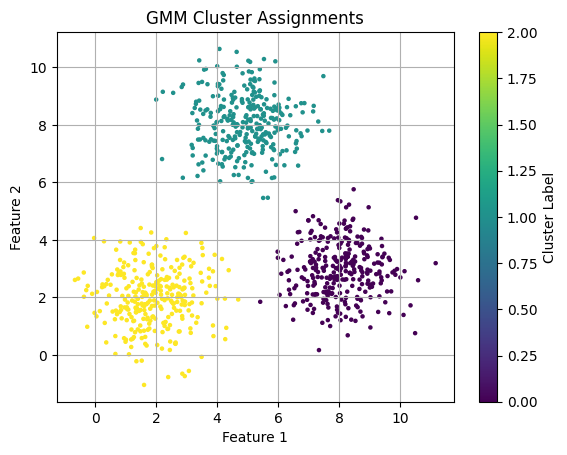

/tmp/ipykernel_31/2550082209.py:25: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(m, width, height, angle, edgecolor='red', facecolor='none', lw=2)


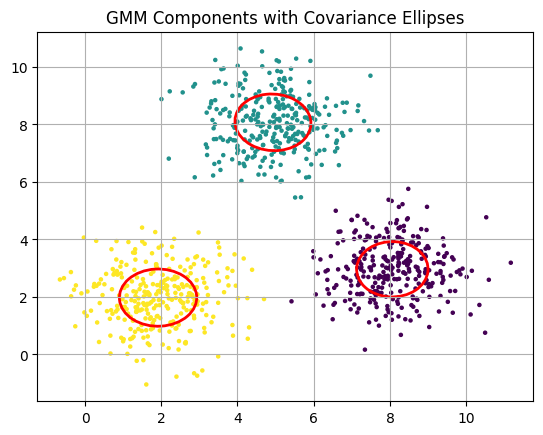

In [23]:
visualize_2d_gmm_clusters(data,gamma)
plot_2d_gmm_with_ellipses(data, mu, cov, gamma)

In [24]:
import os 
os.listdir('/kaggle/input/brain-mri/SMAI Assignment 2')

['sald_031764_probmask_csf.nii',
 'sald_031764_img.nii',
 'sald_031764_probmask_graymatter.nii',
 'sald_031764_probmask_whitematter.nii']

In [25]:
import nibabel as nib
import os
import numpy as np

base_path = '/kaggle/input/brain-mri/SMAI Assignment 2'

def load_nifti(file_name):
    nii = nib.load(os.path.join(base_path, file_name))
    return nii.get_fdata()

# Load original image
img = load_nifti('sald_031764_img.nii')

# Load ground truth probability masks
csf = load_nifti('sald_031764_probmask_csf.nii')
gray = load_nifti('sald_031764_probmask_graymatter.nii')
white = load_nifti('sald_031764_probmask_whitematter.nii')

In [26]:
gt_stack = np.stack([csf, gray, white], axis=-1)
ground_truth_labels = np.argmax(gt_stack, axis=-1)  # 0=csf, 1=gray, 2=white

In [27]:
from sklearn.mixture import GaussianMixture

def segment_image_gmm(image, K=3):
    flat = image.flatten().reshape(-1, 1)
    gmm = GaussianMixture(n_components=K, covariance_type='full', random_state=42)
    gmm.fit(flat)
    preds = gmm.predict(flat)
    segmentation = preds.reshape(image.shape)
    return segmentation

In [28]:
import numpy as np
from sklearn.cluster import KMeans 


def multivariate_gaussian_pdf(X, mu, cov, reg_covar=1e-6):
    """Calculates multivariate Gaussian PDF values."""
    N, D = X.shape if X.ndim > 1 else (1, X.shape[0])
    if X.ndim == 1:
        X = X.reshape(1, D) # Ensure 2D for calculations

    mu = mu.reshape(1, D)
    cov = cov.reshape(D, D)

    # Add regularization for numerical stability before inversion/determinant
    cov_reg = cov + np.eye(D) * reg_covar

    try:
        cov_inv = np.linalg.inv(cov_reg)
        sign, log_det = np.linalg.slogdet(cov_reg)

        if sign <= 0: # Should ideally not happen with regularization
            # print(f"Warning: Non-positive determinant sign ({sign}) for cov:\n{cov_reg}")
            return np.zeros(N)

    except np.linalg.LinAlgError:
        # print(f"Warning: Singular matrix during inversion/determinant for cov:\n{cov_reg}")
        return np.zeros(N) # Return zero probability if singular

    log_2pi = np.log(2 * np.pi)
    log_norm_const = -0.5 * (D * log_2pi + log_det)

    diff = X - mu # Broadcasting (N,D) - (1,D) -> (N,D)
    exponent = np.einsum('ni,ij,nj->n', diff, cov_inv, diff) # Mahalanobis dist^2

    log_pdf = log_norm_const - 0.5 * exponent
    return np.exp(log_pdf)

def initialize_parameters(data, K, random_state=None, reg_covar=1e-6):
    """Initializes GMM parameters using KMeans."""
    N, D = data.shape
    mu = None
    labels = None

    try:
        # Use n_init='auto' or fallback to 10
        try:
            kmeans = KMeans(n_clusters=K, init='k-means++', n_init='auto', max_iter=50, random_state=random_state)
        except TypeError:
             kmeans = KMeans(n_clusters=K, init='k-means++', n_init=10, max_iter=50, random_state=random_state)
        kmeans.fit(data)
        mu = kmeans.cluster_centers_
        labels = kmeans.labels_
    except Exception as e:
        print(f"KMeans init failed: {e}. Using random points for means.")
        # Fallback
        rng = np.random.RandomState(random_state)
        indices = rng.choice(N, K, replace=False)
        mu = data[indices]
        # Assign labels based on fallback means
        from scipy.spatial.distance import cdist
        distances = cdist(data, mu)
        labels = np.argmin(distances, axis=1)

    # Check if K decreased (unlikely but possible)
    if mu.shape[0] != K:
        print(f"Adjusting K from {K} to {mu.shape[0]} based on KMeans output.")
        K = mu.shape[0]

    cov = np.zeros((K, D, D))
    Nk = np.bincount(labels, minlength=K)
    pi = Nk / N

    for k in range(K):
        data_k = data[labels == k]
        if len(data_k) < D + 1 or Nk[k] == 0: # Check Nk[k] as well
            # Fallback if cluster empty or too small
            cov[k] = np.cov(data, rowvar=False) + np.eye(D) * reg_covar
            # If pi[k] is 0, this cov won't matter much initially
        else:
            cov[k] = np.cov(data_k, rowvar=False) + np.eye(D) * reg_covar

    return mu, cov, pi

def e_step(data, mu, cov, pi, reg_covar=1e-6):
    """Performs the E-step of the EM algorithm."""
    N = data.shape[0]
    K = len(pi)
    gamma = np.zeros((N, K))
    likelihoods = np.zeros((N, K)) # Store individual likelihoods

    for k in range(K):
        if pi[k] > 1e-9: # Only compute for components with non-negligible weight
            likelihoods[:, k] = multivariate_gaussian_pdf(data, mu[k], cov[k], reg_covar)
            gamma[:, k] = pi[k] * likelihoods[:, k]
        else:
            gamma[:, k] = 0.0

    sum_gamma = gamma.sum(axis=1, keepdims=True)
    # Add small epsilon for stability before division
    gamma = gamma / np.maximum(sum_gamma, 1e-300)

    # Return both gamma and the per-component likelihoods for LL calculation
    return gamma, likelihoods

def m_step(data, gamma, reg_covar=1e-6):
    """Performs the M-step of the EM algorithm."""
    N, D = data.shape
    K = gamma.shape[1]
    eps = 1e-9 # Avoid division by zero

    Nk = gamma.sum(axis=0) + eps # Add eps here before division

    pi = (Nk - eps) / N # Use original Nk sum for pi
    mu = np.zeros((K, D))
    cov = np.zeros((K, D, D))

    for k in range(K):
        if Nk[k] - eps < eps: # Skip update if component weight is negligible
             # Keep old mu? Set cov to identity? Needs careful thought in prod code.
             # For simplicity, we might leave them as zeros/initial values if never updated.
             # Re-adding regularization might be needed if kept as zeros.
             mu[k] = np.zeros(D) # Or some other default?
             cov[k] = np.eye(D) * reg_covar
             continue

        # Update mu
        mu[k] = (gamma[:, k][:, None] * data).sum(axis=0) / Nk[k]

        # Update cov
        diff = data - mu[k] # Use updated mu
        cov_k_num = (gamma[:, k][:, None, None] * np.einsum('ni,nj->nij', diff, diff)).sum(axis=0)
        cov[k] = cov_k_num / Nk[k] + np.eye(D) * reg_covar # Add regularization

    return mu, cov, pi

def compute_log_likelihood(likelihoods, pi):
    """Computes log likelihood using pre-calculated likelihoods."""
    K = len(pi)
    # weighted_likelihoods = np.zeros_like(likelihoods)
    # for k in range(K):
    #     weighted_likelihoods[:, k] = pi[k] * likelihoods[:, k] # pi already applied in e_step gamma calc
    
    # Likelihoods passed from e_step are already P(x|k) * pi[k] essentially via gamma calc? NO.
    # Need to re-weight likelihoods calculated in e_step (which were P(x|k)) with updated pi
    
    total_likelihood = np.zeros(likelihoods.shape[0])
    for k in range(K):
        total_likelihood += pi[k] * likelihoods[:, k] # Sum_k pi_k * N(x | mu_k, cov_k)

    # Add epsilon before log
    log_likelihood = np.sum(np.log(np.maximum(total_likelihood, 1e-300)))
    return log_likelihood

def fit_gmm(data, K=3, max_iter=100, tol=1e-3, verbose=False, random_state=None, reg_covar=1e-6):
    """Fits a GMM using EM, aiming for sklearn similarity."""

    try:
        mu, cov, pi = initialize_parameters(data, K, random_state=random_state, reg_covar=reg_covar)
    except Exception as e:
        print(f"Initialization failed: {e}. Returning None.")
        return None, None, None, None, []

    log_likelihoods = [-np.inf]
    gamma = None # Initialize gamma

    for iteration in range(max_iter):
        prev_ll = log_likelihoods[-1]

        try:
            # Pass reg_covar to e_step if needed by multivariate_gaussian_pdf
            gamma, likelihoods_per_comp = e_step(data, mu, cov, pi, reg_covar)
        except np.linalg.LinAlgError as e:
             print(f"LinAlgError in E-step iter {iteration}: {e}. Stopping.")
             break
        except Exception as e:
             print(f"Error in E-step iter {iteration}: {e}. Stopping.")
             break


        try:
            mu, cov, pi = m_step(data, gamma, reg_covar)
        except Exception as e:
            print(f"Error in M-step iter {iteration}: {e}. Stopping.")
            break

        try:
            # Pass likelihoods from E-step to avoid recomputing gaussian PDF
            ll = compute_log_likelihood(likelihoods_per_comp, pi)
            log_likelihoods.append(ll)
        except Exception as e:
            print(f"Error computing log likelihood iter {iteration}: {e}. Stopping.")
            # Use previous ll for comparison?
            log_likelihoods.append(prev_ll)
            break


        if verbose:
            print(f"Iteration {iteration}: log-likelihood = {ll:.4f}")

        # Check for convergence / invalid likelihood
        if np.isnan(ll) or np.isinf(ll):
             print(f"Stopping due to invalid log-likelihood ({ll}) at iteration {iteration}.")
             break
        if abs(ll - prev_ll) < tol:
            print(f"Converged at iteration {iteration}")
            break

    log_likelihoods = log_likelihoods[1:] # Remove initial -inf
    return mu, cov, pi, gamma, log_likelihoods


# --- Modified Segmentation Function ---

def segment_image_with_custom_gmm_minimal(image, K=3, max_iter=100, tol=1e-3, random_state=42, reg_covar=1e-6):
    """Segments image using the minimal custom GMM."""
    original_shape = image.shape
    if image.size == 0: return np.zeros(original_shape, dtype=int)

    # Reshape to (N_voxels, 1) - ASSUMES 1D FEATURE (intensity)
    flat_data = image.flatten().reshape(-1, 1)

    if np.all(flat_data == flat_data[0]): # Handle constant image
        return np.zeros(original_shape, dtype=int)

    # Fit Custom GMM
    mu, cov, pi, gamma, _ = fit_gmm(
        data=flat_data,
        K=K,
        max_iter=max_iter,
        tol=tol,
        verbose=False, # Keep segmentation function quiet by default
        random_state=random_state,
        reg_covar=reg_covar
    )

    # Check for fitting failure
    if gamma is None:
        print("Custom GMM fitting failed during segmentation.")
        return None # Or return an empty/default segmentation

    # Predict Labels from Responsibilities
    preds = np.argmax(gamma, axis=1)

    # Reshape Labels
    try:
        segmentation = preds.reshape(original_shape)
    except ValueError:
        print("Error reshaping labels during segmentation.")
        return None

    return segmentation , mu, cov, pi, gamma, _

In [29]:
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix

def match_labels(preds, ground_truth):
    preds_flat = preds.flatten()
    gt_flat = ground_truth.flatten()
    
    cm = confusion_matrix(gt_flat, preds_flat)
    row_ind, col_ind = linear_sum_assignment(-cm)  # maximize total accuracy
    
    mapping = dict(zip(col_ind, row_ind))
    mapped_preds = np.vectorize(mapping.get)(preds)
    return mapped_preds.reshape (preds.shape)

In [30]:
def compute_accuracy(pred_labels, gt_labels):
    return np.mean(pred_labels == gt_labels)

In [31]:
from nibabel import Nifti1Image


def save_segmentation(pred, reference_img_path, out_path='segmentation.nii'):
    reference = nib.load(reference_img_path)
    assert pred.shape == reference.shape, f"Shape mismatch: pred {pred.shape} vs reference {reference.shape}"
    
    # Check unique values
    print("Unique labels in prediction:", np.unique(pred))

    # Save as NIfTI
    nii = Nifti1Image(pred.astype(np.uint8), affine=reference.affine)
    nib.save(nii, out_path)
    print(f"Saved segmentation to {out_path}")

In [32]:
# Segment with GMM
pred_raw, mu, cov, pi, gamma, log_likelihoods = segment_image_with_custom_gmm_minimal(img)

In [33]:
manual_mapping = {
    0: 0,  # GMM 0 → GT 2 (white matter)
    1: 2,  # GMM 1 → GT 1 (gray matter)
    2: 1   # GMM 2 → GT 0 (CSF)
}

# Apply the mapping
pred_mapped_manual = np.zeros_like(pred_raw)
for gmm_label, gt_label in manual_mapping.items():
    pred_mapped_manual[pred_raw == gmm_label] = gt_label

# Save for visualization
save_segmentation(pred_mapped_manual, os.path.join(base_path, 'sald_031764_img.nii'), 'gmm_segmentation.nii')

# Accuracy
acc = compute_accuracy(pred_mapped_manual, ground_truth_labels)
print(f"Pointwise Accuracy: {acc:.4f}")

Unique labels in prediction: [0 1 2]
Saved segmentation to gmm_segmentation.nii
Pointwise Accuracy: 0.8174


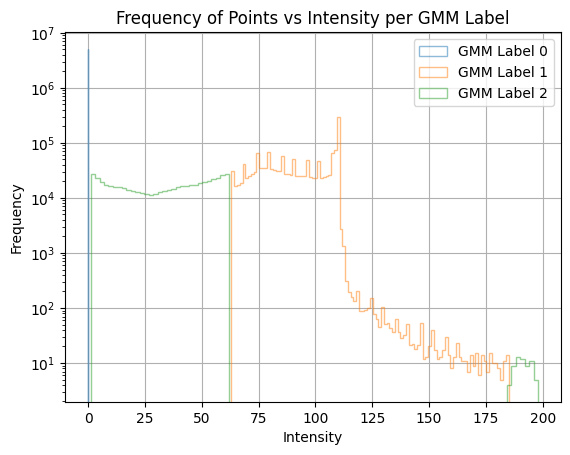

In [53]:
# Assuming you have `img` (intensity) and `pred_raw` (GMM labels)
for i in range(3):
    mask = pred_raw == i
    plt.hist(img[mask].ravel(), bins=100, alpha=0.5, label=f'GMM Label {i}', histtype='step')

plt.title('Frequency of Points vs Intensity per GMM Label')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.yscale('log')  # Adjust to see low-freq patterns
plt.legend()
plt.grid(True)
plt.show()

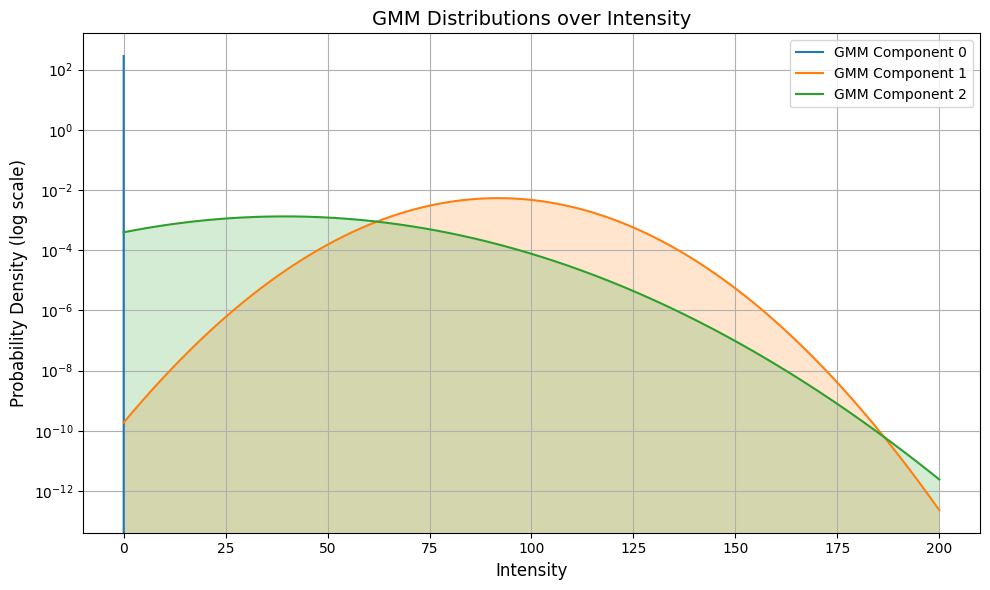

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

x = np.linspace(0, 200, 500)

plt.figure(figsize=(10, 6))
for i in range(3):
    mean_intensity = mu[i][0]
    std_intensity = np.sqrt(cov[i][0][0])
    pdf = pi[i] * norm.pdf(x, loc=mean_intensity, scale=std_intensity)
    
    plt.plot(x, pdf, label=f'GMM Component {i}')
    plt.fill_between(x, pdf, alpha=0.2)

plt.yscale('log')  # Option A
# plt.ylim(top=5)   # Option B instead of log, if preferred

plt.title('GMM Distributions over Intensity', fontsize=14)
plt.xlabel('Intensity', fontsize=12)
plt.ylabel('Probability Density (log scale)', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [34]:
from ipywidgets import interact
import matplotlib.pyplot as plt

def visualize_slice_interactive(img, gt, pred):
    def plot_slice(slice_idx):
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(img[:, :, slice_idx], cmap='gray')
        plt.title(f'Original MRI (slice {slice_idx})')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(gt[:, :, slice_idx], cmap='tab10')
        plt.title('Ground Truth')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(pred[:, :, slice_idx], cmap='tab10')
        plt.title('GMM Segmentation')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    interact(plot_slice, slice_idx=(0, img.shape[2] - 1))

visualize_slice_interactive(img, ground_truth_labels, pred_mapped_manual)

interactive(children=(IntSlider(value=90, description='slice_idx', max=181), Output()), _dom_classes=('widget-…